In [146]:
import torch
from torch import nn, optim
from torch.nn import Linear
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from ipywidgets import interact, widgets, Layout
%matplotlib inline

## Logistic Regression two classes

In [9]:
class Data_2(Dataset):
    def __init__(self, soft_max=False):
        self.x = torch.arange(-2, 2, 0.1).view(-1, 1)
        if soft_max:
            self.y = torch.zeros(self.x.shape[0])
        else:
            self.y = torch.zeros(self.x.shape[0], 1)
        self.y[self.x[:, 0] > 0.5] = 1
        if soft_max:
            self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len


def plot_data_2(data, model, est_line=False, soft_max=False):
    if est_line:
        plt.plot(data.x,
                 torch.sigmoid(list(model.parameters())[0].item() * data.x + list(model.parameters())[1].item()),
                 color='black',
                 label='estimated decision boundary')
    if soft_max:
        X = data[:][0]
        Y = data[:][1]
        w = list(model.parameters())[0][0].detach()
        b = list(model.parameters())[1][0].detach()
        y_label = ['yhat=0', 'yhat=1']
        y_color = ['r', 'b']
        Y = []
        for w, b, y_l, y_c in zip(model.state_dict()['0.weight'], model.state_dict()['0.bias'], y_label, y_color):
            Y.append((w * X + b).numpy())
            plt.plot(X.numpy(), (w * X + b).numpy(), y_c, label=y_l)
    plt.plot(data.x.numpy()[(data.y == 0)], data.y.numpy()[(data.y == 0)], 'ro', label="class 1")
    plt.plot(data.x.numpy()[(data.y == 1)], 0 * data.y.numpy()[(data.y == 1)], 'bo', label="class 2")
    plt.legend()
    plt.ylim(-0.5, 3)
    plt.show()#%%

In [10]:
data_2 = Data_2()

In [11]:
class logistic_regression(nn.Module):
    def __init__(self,n_inputs):
        super(logistic_regression, self).__init__()
        self.linear = nn.Linear(n_inputs,1)
        
    def forward(self,x):
        return torch.sigmoid(self.linear(x))

def BinaryCELoss(yhat,y):
    eps = 9e-10
    return -1*torch.mean(y*torch.log(yhat+eps)+(1-y)*torch.log(1-yhat+eps))

## Derivation of the cross entropy error in a two class setting
Assume we have a two-class classification problem with class labels $0$ and $1$, and a labeled datasample $(x_1,y_1),...,(x_N,y_N),, N\in\mathbb{N}$ with $x_i \in\mathbb{R}$ for all $i\in\{1,...,N\}$.
Let's say there is some $n \in\mathbb{N}$ with $1<n<N$ such that $y_i = 0$ for all $i<n$ and $y_i = 1$ for all $i\geq n$.
Then, we are interested in maximizing the probability
\begin{equation}
    \mathbb{P}(Y|wX+b):=\prod_{i=1}^{n-1}\mathbb{P}(y_i= 0|wx_i+b)\prod_{i=n}^{N}\mathbb{P}(y_i= 1|wx_i+b),
\end{equation}
where $Y=(y_1,...,y_N)$, $X = (x_1,...,x_N)$, and $w,b \in\mathbb{R}$, as this yields the optimal estimation for the parameters $w$ and $b$.

*Remark: Delete "Note" and argue why we can use sigmoid function as probabilities.*
Note, that 
\begin{align}
   \mathbb{P}(y_i= 0|wx_i+b) &= 1-\sigma(wx_i+b),\\
   \mathbb{P}(y_i= 1|wx_i+b) &= \sigma(wx_i+b),
\end{align}
where $\sigma$ denotes the sigmoid function, i.e., $\sigma:\mathbb{R}\to [0,1],\,\sigma(x) = \frac{e^x}{e^x+1}$.
Then,
\begin{align}
    \mathbb{P}(Y|wX+b) = \prod_{i=1}^{n-1}1-\sigma(wx_i+b)\prod_{i=n}^{N}\sigma(wx_i+b).
\end{align}
Since $y_i \in\{0,1\}$ for all $i\in\{1,...,N\}$, the expression above is equivalent to
\begin{equation}
    \mathbb{P}(Y|wX+b) = \prod_{i=1}^{N}(1-\sigma(wx_i+b))^{1-y_i}\sigma(wx_i+b)^{y_i}
\end{equation}
which can be maximized by applying maximum likelihood estimation.

Recall, that
\begin{equation}
    \underset{w,b}{\text{argmax }}\mathbb{P}(Y|wX+b) = \underset{w,b}{\text{argmax }}\log\left(\mathbb{P}(Y|wX+b)\right),
\end{equation}
since the logartihm is monotonically increasing. Thus, we can apply the logarithm to $\mathbb{P}(Y|wX+b)$ which yields
\begin{align}
    \log\left(\mathbb{P}(Y|wX+b)\right) &= \sum_{n=1}^{N}\log\left((1-\sigma(wx_i+b))^{1-y_i}\cdot\sigma(wx_i+b)^{y_i}\right)\\
                                        &= \sum_{n=1}^{N}(1-y_i)\log(1-\sigma(wx_i+b))\cdot y_i\log(\sigma(wx_i+b))
\end{align}
Instead of maximizing $\log\left(\mathbb{P}(Y|wX+b)\right)$ we can quivalently minimize $(-1)\log\left(\mathbb{P}(Y|wX+b)\right)$. We can also average the latter which yields
\begin{align}
     -\frac{1}{N}\log\left(\mathbb{P}(Y|wX+b)\right) &= -\frac{1}{N}\sum_{n=1}^{N}(1-y_i)\log(1-\sigma(wx_i+b))\cdot y_i\log(\sigma(wx_i+b))\\
     &=-\frac{1}{N}\sum_{n=1}^{N}(1-y_i)\log(1-\hat y_i)\cdot y_i\log(\hat y_i) =: \text{CEL}(\hat Y, Y),
\end{align}
where $\hat y = \sigma(wx+b)$.
$\text{CEL}(\hat Y, Y)$ is nothing but the cross-entropy loss.
The cross-entropy loss can simply be minimized by applying an appropriate algorithm like stochastic gradient descent.

In [12]:
model = logistic_regression(1)
lr = 1
criterion_rms = nn.BCELoss()
criterion_mse = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
trainloader = DataLoader(dataset = data_2, batch_size = 2)

In [13]:
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.3220]])),
             ('linear.bias', tensor([-0.7328]))])

In [14]:
def train_model(epochs):
    LOSS = []
    for iter in range(epochs):
        for x,y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion_rms(yhat,y)
            loss.backward()
            optimizer.step()
        LOSS.append(loss.data)
    plot_data_2(data_2, model, est_line = True)
    plt.plot(np.arange(0,epochs,1),LOSS)

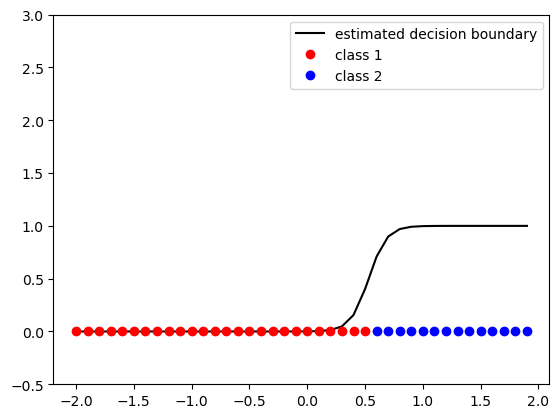

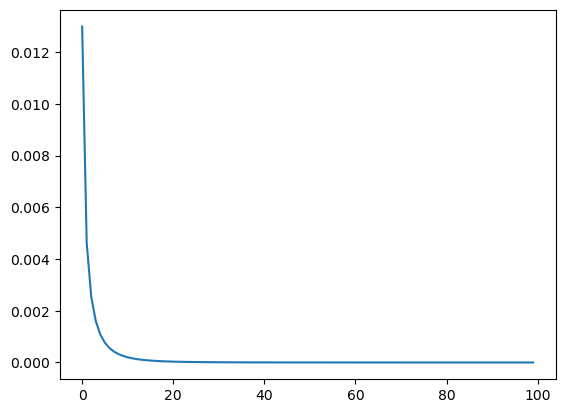

In [15]:
est = train_model(100)

In [16]:
yhat = model(data_2.x)
label = yhat > 0.5
print("Accuracy: ",torch.mean((label==data_2.y.type(torch.ByteTensor)).type(torch.float)))

Accuracy:  tensor(1.)


## Softmax Classification Binary Data in 1D

In [17]:
data_2 = Data_2(soft_max = True)

In [18]:
def loss_bs_1(yhat):
    return -1*torch.log(torch.exp(yhat)/torch.sum(torch.exp(yhat)))

def crossentropyloss(yhat,y):
    max_val, _ = torch.max(yhat, dim=1, keepdim=True)
    tmp = torch.log(torch.sum(torch.exp(yhat - max_val), dim=1)) + max_val.squeeze(dim=1)
    log = yhat - tmp.view(-1,1)
    res = torch.abs(torch.gather(log, 1, y.view(-1,1)).squeeze(1).mean())
    return res

Here's a step-by-step breakdown of what the code does:

1. `max_val, _ = torch.max(yhat, dim=1, keepdim=True)` finds the maximum value along the second dimension of yhat, which represents the predicted scores for each class. The `keepdim=True` argument keeps the second dimension as a singleton dimension.
2. `tmp = torch.log(torch.sum(torch.exp(yhat - max_val),1)).view(-1,1) + max_val` computes a temporary variable that is used to stabilize the computation of the log-.
3. The `torch.exp(yhat - max_val)` term ensures that the largest value in yhat is subtracted from all elements of yhat before exponentiation, thus avoiding overflow issues.
4. `torch.sum(...,1)` sums the exponentiated scores for each class along the second dimension, and `torch.log(...)` computes the natural logarithm of the sum.
5. The `view(-1,1)` operation reshapes the result to have a single column and a number of rows equal to the number of instances in the batch. Finally, `+ max_val` adds the maximum value found in step 1 to the log-sum term element-wise.
6. `log = yhat - tmp` computes the log-softmax of the predicted scores for each class by subtracting the temporary variable computed in step 2 from `yhat`.
7. `torch.gather(log, 1, y.view(-1,1))` selects the log-softmax score for the true class `y` for each instance in the batch.
8. `y.view(-1,1)` reshapes `y` to a column tensor with the same number of rows as `log`.
9. `torch.abs(...)` takes the absolute value of the tensor from step 4.
10. `squeeze(1)` removes the singleton dimension of the tensor from step 5.
11. `mean()` computes the mean of the tensor from step 6 over all instances in the batch.
12. `return res` returns the mean absolute value of the log- score for the true class, which is the cross-entropy loss.

In [19]:
model = nn.Sequential(nn.Linear(1, 2))
criterion_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.5)
trainloader = DataLoader(dataset = data_2, batch_size = 5)

In [20]:
def train_model(epochs):
    LOSS = []
    for iter in range(epochs):
        for x,y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion_CEL(yhat,y)
            loss.backward()
            optimizer.step()
        LOSS.append(loss.data)
    plot_data_2(data_2, model,soft_max=True)
    plt.plot(np.arange(0,epochs,1),LOSS)

In [21]:
def _result(x):
    x = torch.tensor(float(x),requires_grad = True).view(-1,1)
    yhat = model(x).detach().numpy()
    return np.argmax(yhat)+1

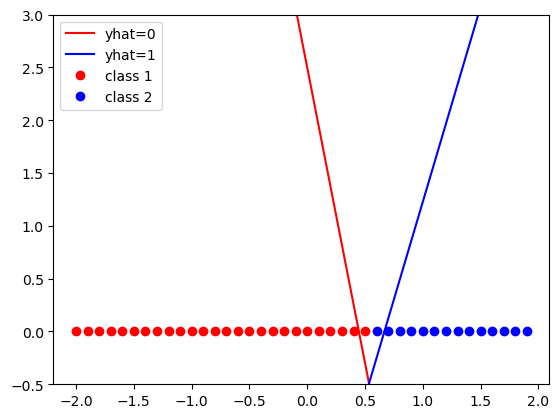

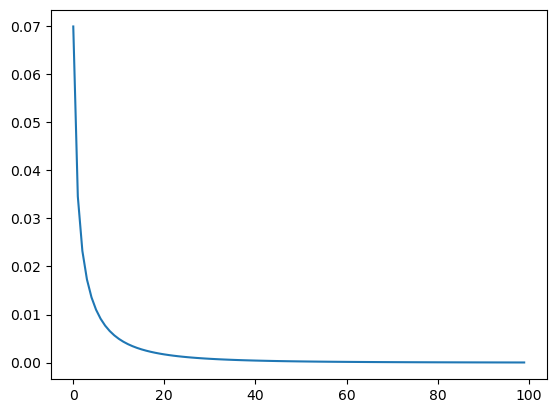

In [22]:
train_model(100)

In [23]:
class Data_2_mixed(Dataset):
    def __init__(self, soft_max = False):
        self.x = torch.arange(-2,2,0.1).view(-1,1)
        if soft_max:
            self.y = torch.zeros(self.x.shape[0])
        else:       
            self.y = torch.zeros(self.x.shape[0],1)
        self.y[(self.x[:,0]>-1) & (self.x[:,0]<1)] = 1
        if soft_max:
            self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.len

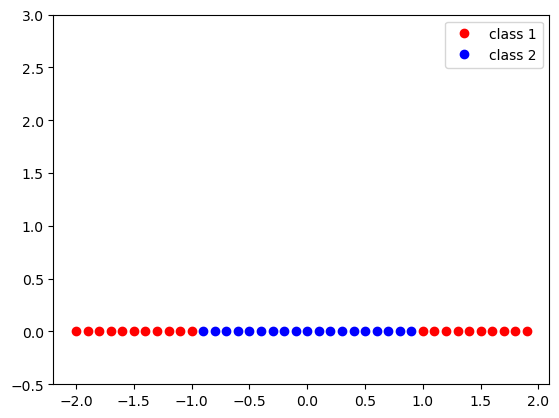

In [24]:
data_2_mixed = Data_2_mixed(soft_max = True)
plot_data_2(data_2_mixed, model = None)

In [25]:
model = nn.Sequential(nn.Linear(1, 2))
#criterion_CEL = crossentropyloss
criterion_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.5)
trainloader = DataLoader(dataset = data_2_mixed, batch_size = 5)

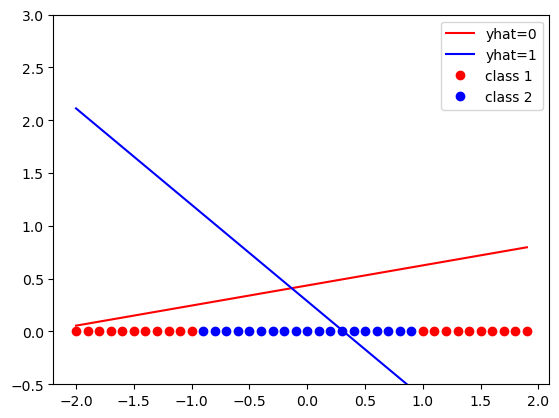

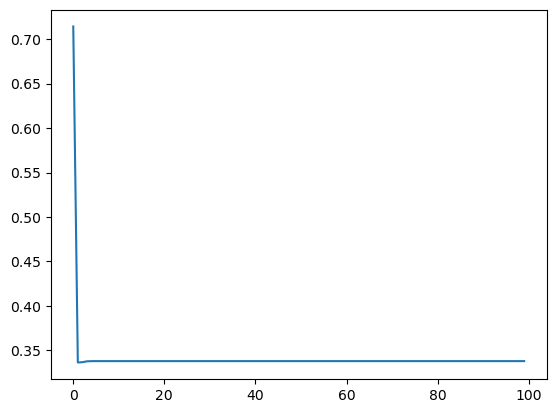

In [26]:
def train_model(epochs,plot_data = False):
    LOSS = []
    for iter in range(epochs):
        for x,y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion_CEL(yhat,y)
            loss.backward()
            optimizer.step()
        LOSS.append(loss.data)
    if plot_data:
        plot_data_2(data_2_mixed, model,soft_max=True)
        plt.plot(np.arange(0,epochs,1),LOSS)
train_model(100, plot_data=True)

In order to obtain a more satisfactory result for the classification problem, a simple  algorithm will not suffice.
As the underlying problem is a two class classification problem, one idea would be to add two logistic models in a way that one curve has a negative sign and is therefore inverted.
A visualization of the idea can be found below.



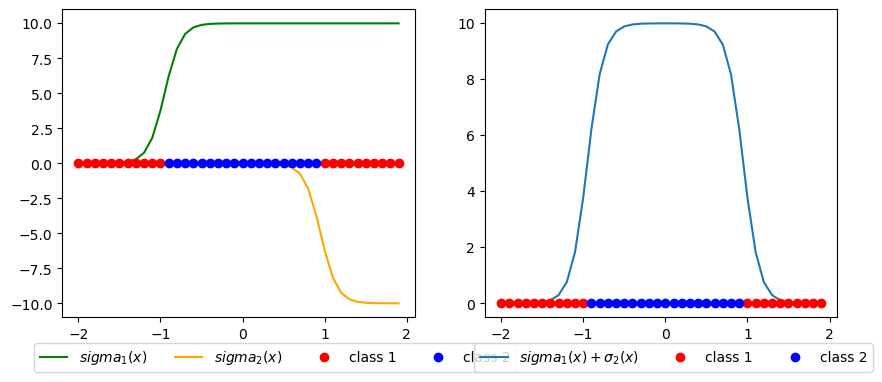

In [27]:
x = np.arange(-2,2,0.1)
def sig1(x,w11,w21,b11):
    return w21/(1 + np.exp(-1 *(b11+w11*x)))
def sig2(x,w12,w22,b12):
    return w22/(1 + np.exp(-1 *(b12+w12*x)))
def h(x,w11,w12,w21,w22,b11,b12):
    tmp1 = sig1(x,w11,w21,b11)
    tmp2 = sig2(x,w12,w22,b12)
    return tmp1+tmp2
[w11,w12,w21,w22,b11,b12] = [10,10,10,-10,9.5,-9.5]
data = data_2_mixed
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x,sig1(x,w11,w21,b11), label = "$sigma_1(x)$", color = "green")
plt.plot(x,sig2(x,w12,w22,b12), label = "$sigma_2(x)$", color = "orange")
plt.plot(data.x.numpy()[(data.y == 0)],data.y.numpy()[(data.y == 0)], 'ro',label="class 1")
plt.plot(data.x.numpy()[(data.y == 1)],0*data.y.numpy()[(data.y == 1)], 'bo',label="class 2")
plt.legend(bbox_to_anchor=(-0.1, -0.2), loc="lower left",ncol = 4)

plt.subplot(1,2,2)
plt.plot(x,h(x,w11,w12,w21,w22,b11,b12), label = "$sigma_1(x)+\sigma_2(x)$")
plt.plot(data.x.numpy()[(data.y == 0)],data.y.numpy()[(data.y == 0)], 'ro',label="class 1")
plt.plot(data.x.numpy()[(data.y == 1)],0*data.y.numpy()[(data.y == 1)], 'bo',label="class 2")
plt.legend(bbox_to_anchor=(-0.05, -0.2), loc="lower left",ncol = 3)



A mamthematical formulation of the procedure above is the following.
Let
\begin{alignat}{2}
    &l_1:\mathbb{R}\rightarrow\mathbb{R}^2,\quad l_1(x) &&= \begin{pmatrix}b_1^1 \\ b_2^1 \end{pmatrix} + \begin{pmatrix}w_1^1,\\ w_2^1\end{pmatrix} x\\
    &l_2:\mathbb{R^2}\rightarrow\mathbb{R},\quad l_2(x_1,x_2) &&=  b_2^2 + \begin{pmatrix}w_1^2\\ w_2^2\end{pmatrix}^\top \begin{pmatrix}x_1\\ x_2 \end{pmatrix}
\end{alignat}
with $b_i^1, b_2^2, w_i^2, w_1, \in\mathbb{R}, \, i=1,2$.
Then, the model
\begin{equation}
m : \mathbb{R}\to\mathbb{R},\quad m(x) = (l_2 \circ \sigma \circ l_1) (x)
\end{equation}
describes the procedure above. Note, that in the plot above $b_2^2 = 0$.


The closed form of $m$ is given by
\begin{align}
m(x) = b_2^2 + \frac{w_1^2}{1+\exp(-(b_1^1 + w_1^1 x))} + \frac{w_2^2}{1+\exp(-(b^1_2+w^1_2 x))}.
\end{align}
If the sign of $w_2^2$ is negative, the desired effect of an inverted logistic curve is obtained.
In order to scale the curve to values to the interval $[0,1]$, the sigmoid function can be applied to $m$ again, as it doesn't change the behavior of $m$.
The resulting model is then given by

\begin{equation}
    \tilde m(x) =  (\sigma \circ l_2 \circ \sigma \circ l_1) (x)
\end{equation}
which has the closed form
\begin{equation}
    \tilde m(x) = \frac{1}{1+\exp\bigg(-\big(b_2^2 + \frac{w_1^2}{1+\exp(-(b_1^1 + w_1^1 x))} + \frac{w_2^2}{1+\exp(-(b^1_2+w^1_2 x))}\big)\bigg)}.
\end{equation}
The interactive plot below lets you experiment, how the curve changes depending on the weight parameters $w_i^j, , i,j=1,2$.

In [28]:
x = np.arange(-2,2,0.1)
def f(x,w11,w12,w21,w22):
    tmp1 = w21/(1 + np.exp(-1 *(5+w11*x)))
    tmp2 = w22/(1 + np.exp(-1 *(-5+w12*x)))
    tmp3 = 1+np.exp(-1 *(tmp1+tmp2))
    return tmp3

[w11,w12,w21,w22,b11,b12,b22] = [9.0756,10.0023,13.75,-14.422,8.4540,-9.3548,-6.2917]
[w11_,w12_,w21_,w22_,b11_,b12_,b22_] = [9.0756,10.0023,13.75,-14.422,8.4540,-9.3548,-6.2917]

def plot_nn(w11,w12,w21,w22):
    y = f(x,w11,w12,w21,w22)
    data = data_2_mixed
    plt.plot(data.x.numpy()[(data.y == 0)],data.y.numpy()[(data.y == 0)], 'ro',label="class 1")
    plt.plot(data.x.numpy()[(data.y == 1)],0*data.y.numpy()[(data.y == 1)], 'bo',label="class 2")
    plt.plot(x,y)

style = {'description_width': 'initial'}
layout = Layout(width = "400px")

slid1 = widgets.FloatSlider(description = '$w_1^1$',min=-5, max=5, step=0.01, value=0.0,style = style, layout = layout)
slid2 = widgets.FloatSlider(description = '$w_1^2$',min=-5, max=5, step=0.01, value=0.0,style = style, layout = layout)
slid3 = widgets.FloatSlider(description = '$w_2^1$',min=-5, max=5, step=0.01, value=0.0,style = style, layout = layout)
slid4 = widgets.FloatSlider(description = '$w_2^2$',min=-5, max=5, step=0.01, value=0.0,style = style, layout = layout)


interact(plot_nn, w11 = slid1, w12 = slid2, w21 = slid3, w22 = slid4)



interactive(children=(FloatSlider(value=0.0, description='$w_1^1$', layout=Layout(width='400px'), max=5.0, min…

<function __main__.plot_nn(w11, w12, w21, w22)>

In order to fit the parameters for a good result we can make use of previous methods using the ``pytorch`` framework.

In [29]:
class multi_log(nn.Module):
    def __init__(self, n_in,L,n_out):
        super(multi_log,self).__init__()
        self.linear1 = nn.Linear(n_in,L)
        self.linear2 = nn.Linear(L,n_out)
        self.activation,self.layer1,self.layer2 = None,None,None
    def forward(self,x):
        self.layer1=self.linear1(x)
        self.activation = torch.sigmoid(self.layer1)
        self.layer2 = self.linear2(self.activation)

        return torch.sigmoid(self.layer2)

In [30]:
model = multi_log(1, 2, 1)

In [31]:
data_2_mixed = Data_2_mixed()

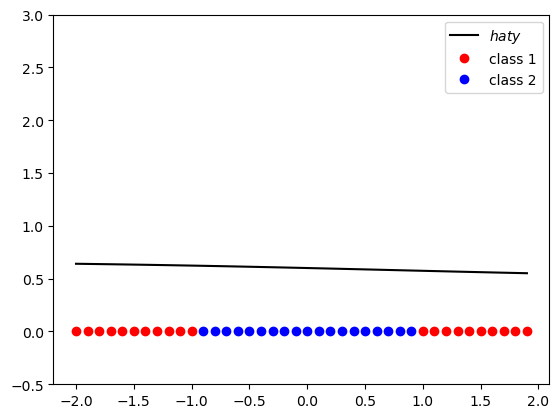

In [32]:
model = multi_log(1, 2, 1)
plt.plot(data_2_mixed.x.detach().numpy(),model(data_2_mixed.x).detach().numpy(), color = 'black',label = '$hat y$')
plot_data_2(data_2_mixed, model)

In [33]:
#criterion_CEL = nn.BCELoss()
criterion_CEL = BinaryCELoss
optimizer = torch.optim.SGD(model.parameters(), lr = 0.5)
trainloader = DataLoader(dataset = data_2_mixed, batch_size = 5)
train_model(500)

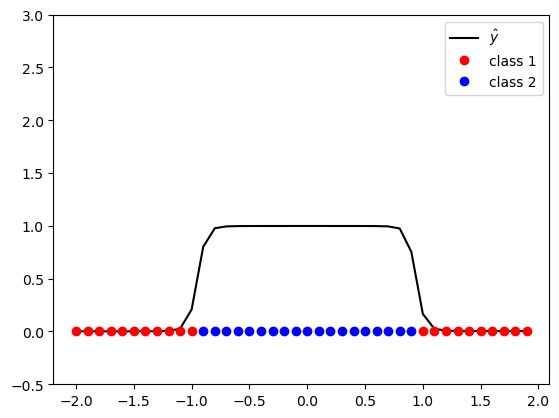

OrderedDict([('linear1.weight', tensor([[-9.0285],
        [-8.2926]])), ('linear1.bias', tensor([ 8.2938, -7.8268])), ('linear2.weight', tensor([[ 12.5810, -13.3838]])), ('linear2.bias', tensor([-5.6968]))])


In [34]:
plt.plot(data_2_mixed.x.detach().numpy(),model(data_2_mixed.x).detach().numpy(), color = 'black',label = '$\hat y$')
plot_data_2(data_2_mixed, model)
print(model.state_dict())

The model above is not only an extended logstic model but also a neural network with one hidden layer and two neurons!
In the definition of $\tilde m$, $l_1$ is the hidden layer and $(\sigma \circ l_1)$ is the so-called *activation* function.
The number of neurons in the neural net above is given by the dimension of the output of the first layer $l_1$.

By introducing more neurons in the hidden layer, we can accurately classify data which is even more convoluted.
It is worth noting, that an increase in neurons (and subsequently parameters in the model) leads to an increased difficulty in the optimization problem.
using stochastic gradient descent for solving these kinds of high dimensional optimization problems requires more epochs to reach an optimal result.
An alternative optimization algorithm is the so-called "Adam" (Adaptive momentum estimation) algorithm, which we will not discuss in detail here.
However, we will now move on to multi-class data and discuss the effect of adding more neurons in a later section.

## Softmax Classifiaction Multiclass Data in 1D

Before introducing neural networks for classification tasks with multiclass data, we have to take one step back and introduce  classification for multiclass data.
Softmax classification works well with data that is linearly separable as we have seen in the two-class setting.
Let us therefore start out with data that is linearly separable.

In [35]:
class Data_3(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-2, 2, 0.1).view(-1, 1)
        self.y = torch.zeros(self.x.shape[0])
        self.y[(self.x > -1.0)[:, 0] * (self.x < 1.0)[:, 0]] = 1
        self.y[(self.x >= 1.0)[:, 0]] = 2
        self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len



def plot_data_3(data,est_line = False):
    plt.plot(data.x.numpy()[(data.y == 0)],data.y.numpy()[(data.y == 0)], 'ro',label="class 1")
    plt.plot(data.x.numpy()[(data.y == 1)],0*data.y.numpy()[(data.y == 1)], 'bo',label="class 2")
    plt.plot(data.x.numpy()[(data.y == 2)],0*data.y.numpy()[(data.y == 2)], 'go',label="class 3")
    if est_line:
        plt.plot(data.x, list(model.parameters())[0][0].item() * data.x + list(model.parameters())[1][0].item(),
                 color = 'red',
                 label = 'regression line class 1')
        plt.plot(data.x, list(model.parameters())[0][1].item() * data.x + list(model.parameters())[1][1].item(),
                 color = 'blue',
                 label = 'regression line class 2')
        plt.plot(data.x, list(model.parameters())[0][2].item() * data.x + list(model.parameters())[1][2].item(),
                 color = 'green',
                 label = 'regression line class 3')
    plt.legend()
    plt.ylim(-0.5,3)
    plt.show()

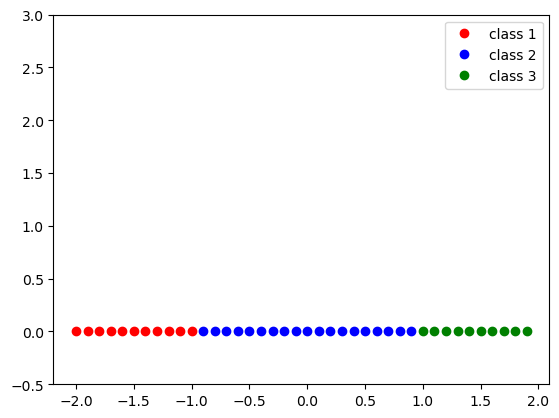

In [36]:
data_3 = Data_3()
plot_data_3(data_3)

In [37]:
model = nn.Sequential(nn.Linear(1, 3))
criterion_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
trainloader = DataLoader(dataset = data_3, batch_size = 5)

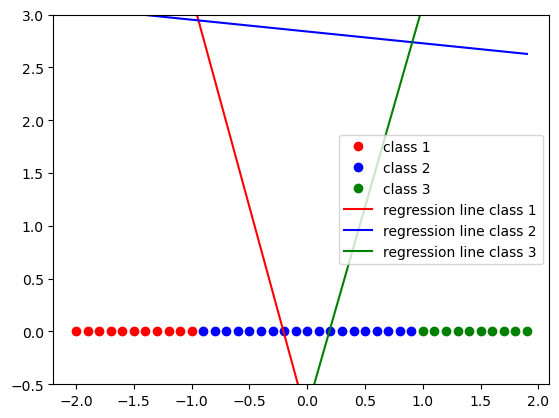

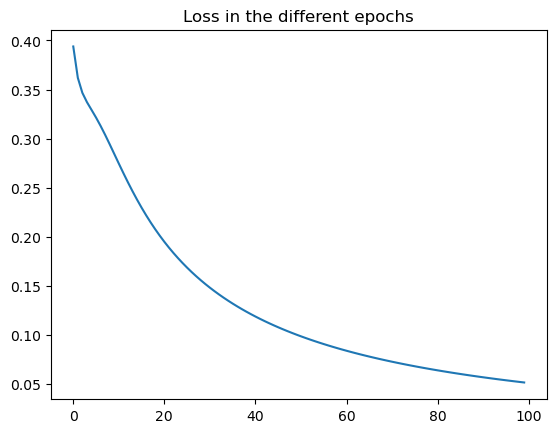

In [38]:
def train_model(epochs):
    LOSS = []
    for epoch in range(epochs):
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion_CEL(yhat, y)
            loss.backward()
            optimizer.step()
        LOSS.append(loss.data)
    plot_data_3(data_3,est_line=True)
    plt.plot(np.arange(0,epochs,1),LOSS)
    plt.title("Loss in the different epochs")
train_model(100)

In [39]:
Softmax_fn=nn.Softmax(dim=-1)
Probability =Softmax_fn(model(torch.tensor([[0.5]])))
for i in range(3):
    print("probability of class {} is given by  {}".format(i+1, Probability[0,i]))


probability of class 1 is given by  0.003034481778740883
probability of class 2 is given by  0.8301213383674622
probability of class 3 is given by  0.1668441891670227


In [40]:
class Data_3_Mixed(Dataset):

    def __init__(self):
        self.x = torch.arange(-2,2,0.1).view(-1,1)
        self.y = torch.zeros(self.x.shape[0])
        self.y[(self.x<-1.5)[:, 0]|(self.x>1.5)[:, 0]] = 1
        self.y[((self.x>=-1.5)[:, 0]&(self.x<-0.5)[:, 0])|((self.x>0.5)[:, 0]&(self.x<=1.5)[:, 0])] = 2
        self.y = self.y.type(torch.LongTensor)
        self.len = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.len


In [41]:
class Net(nn.Module):
    def __init__(self, n_in,L,n_out):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(n_in,L)
        self.linear2 = nn.Linear(L,n_out)
    def forward(self,x):
        self.layer1 = torch.sigmoid(self.linear1(x))
        self.layer2 = self.linear2(self.layer1)
        return self.layer2

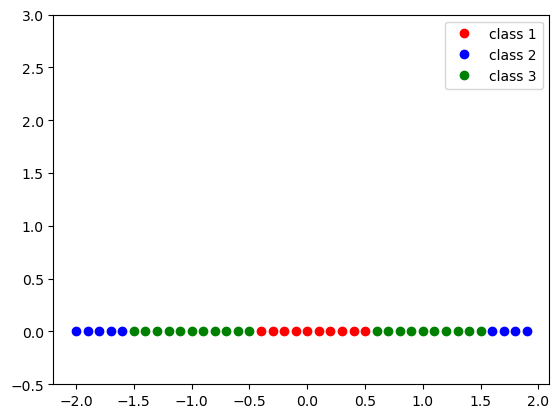

In [42]:
data_3_mixed = Data_3_Mixed()
plot_data_3(data_3_mixed)

In [43]:
model = Net(1,10,3)
criterion_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
trainloader = DataLoader(dataset = data_3_mixed, batch_size = 5)

In [44]:
def train_model(epochs):
    LOSS = []
    for epoch in range(epochs):
        for x, y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion_CEL(yhat, y)
            loss.backward()
            optimizer.step()
        LOSS.append(loss.data)


In [45]:
train_model(1000)

In [46]:
def classifier(x):
    Softmax_fn=nn.Softmax(dim=-1)
    x_ = torch.tensor(float(x),requires_grad = True).view(-1,1)
    probability = Softmax_fn(model(x_))
    print("The point {0} is most likely in class {1} with probability {2:.2f}".format(x,np.argmax(probability.detach().numpy())+1,np.max(probability.detach().numpy())))


In [47]:
classifier(-2)


The point -2 is most likely in class 2 with probability 0.97


*TODO:* Draw decision boundaries on two dimensional plane

In [48]:
xx,yy = np.meshgrid(data_3_mixed.x,np.arange(-0.2,0.2,0.05))
XX = torch.tensor(np.c_[xx.ravel()])
_,yhat = torch.max(model(XX),1)
zz = yhat.detach().numpy().reshape(xx.shape)
#print(model(

(-0.5, 3.0)

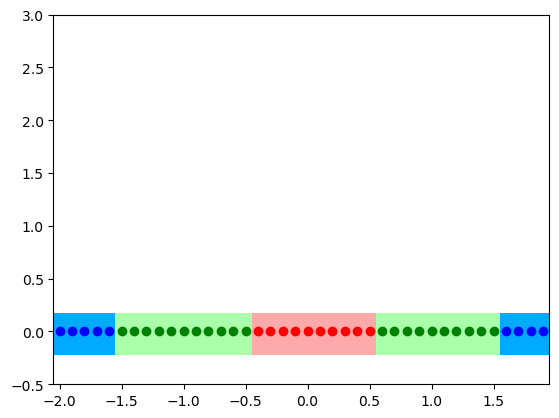

In [49]:
cmap_light = ListedColormap(['#FFAAAA', '#00AAFF', '#AAFFAA'])
data = data_3_mixed
plt.plot(data.x.numpy()[(data.y == 0)],data.y.numpy()[(data.y == 0)], 'ro',label="class 1")
plt.plot(data.x.numpy()[(data.y == 1)],0*data.y.numpy()[(data.y == 1)], 'bo',label="class 2")
plt.plot(data.x.numpy()[(data.y == 2)],0*data.y.numpy()[(data.y == 2)], 'go',label="class 3")

plt.pcolormesh(xx,yy,zz, cmap=cmap_light)
plt.ylim(-0.5,3)


In [50]:
def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

In [51]:
#plot_decision_regions_3class(model,data_3_mixed)

A bit more interesting than classifying random points on a line is classifying images.
MNIST database provides  70,000 labeled images of numbers that will help train our model in the following.

In [54]:
remote = 'C:/Users/Rick/Documents/Blog/posts/post-with-code/Pytorch'
local = 'C:/Users/lachlinu/PycharmProjects/Blog/posts/post-with-code/Pytorch'
train_dataset = dsets.MNIST(root=remote, train=True, download=False, transform=transforms.ToTensor())
test_dataset = dsets.MNIST(root=remote, train=False, download=False, transform=transforms.ToTensor())

Each sample in the dataset is a tuple consisting of the image in form of a `[1,28,28]` array in the first element and an integer which represents the number as a second element.
Here is the first datapoint of the training set as a plot with the corresponding lable in the title.

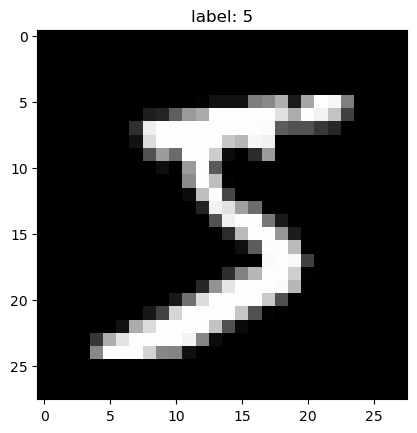

In [55]:
plt.title('label: {}'.format(train_dataset[0][1]))
plt.imshow(train_dataset[0][0].numpy().reshape(28,28),cmap='gray')

Let us first use the previously introduced softmax algorithm as a benchmark model and see how it performs.

In [70]:
input_dim = 28**2
output_dim = 10
model_SF = nn.Sequential(nn.Linear(input_dim, output_dim))
criterion_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_SF.parameters(), lr = 0.1)
trainloader = DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = DataLoader(dataset= test_dataset, batch_size=1000)

In [71]:
def train_model_MNIST_softmax(epochs, model):
    N_test = len(test_dataset)
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x,y in trainloader:
            optimizer.zero_grad()
            yhat = model(x.view(-1,28**2))
            loss = criterion_CEL(yhat,y)
            loss.backward()
            optimizer.step()
        correct = 0
        for xt,yt in validation_loader:
            yt_hat = model(xt.view(-1,28**2))
            _, yt_hat = torch.max(yt_hat.data,1)
            correct += (yt_hat == yt).sum().item()
            acc = correct/N_test
        LOSS.append(loss.data)
        ACC.append(acc)
        if (epoch+1)%5 == 0:
            print("epoch: {}".format(epoch+1))
    return LOSS, ACC


In [72]:
LOSS, ACC = train_model_MNIST_softmax(20, model_SF)

epoch: 5
epoch: 10
epoch: 15
epoch: 20


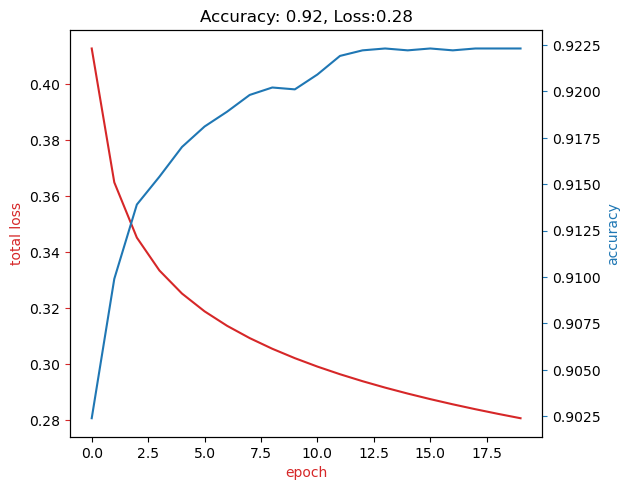

In [73]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(ACC, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.title("Accuracy: {0:.2f}, Loss:{1:.2f}".format(ACC[-1],LOSS[-1]));

In [74]:
Softmax_fn=nn.Softmax(dim=-1)
#count = 0
#for x, y in test_dataset:
#    z = model_SF(x.reshape(-1, 28 * 28))
#    _, yhat = torch.max(z, 1)
#    if yhat != y:
#        plt.title('label: {}'.format(y))
#        plt.imshow(x.numpy().reshape(28,28),cmap='gray')
#        plt.show()
#        print("yhat:", yhat)
#        print("probability of class ", torch.max(Softmax_fn(z)).item())
#        count += 1
#    if count >= 5:
#        break

In [75]:
from PIL import ImageTk, Image, ImageDraw
import PIL
import tkinter as tk

def draw_number():
    width, height = 200, 200  # canvas width
    center = height//2
    black = (0,0,0) # canvas back

    def save():
        # save image to hard drive
        filename = "user_input.jpg"
        output_image.save(filename)

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="white",width=20)
        draw.line([x1, y1, x2, y2],fill="white",width=20)

    master = tk.Tk()

    # create a tkinter canvas to draw on
    canvas = tk.Canvas(master, width=width, height=height, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("L", (width, height))
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=tk.YES, fill=tk.BOTH)
    canvas.bind("<B1-Motion>", paint)


    #add a button to save the image
    button=tk.Button(text="save",command=save)
    button.pack()

    master.mainloop()


The softmax model deems the input as the number 3.


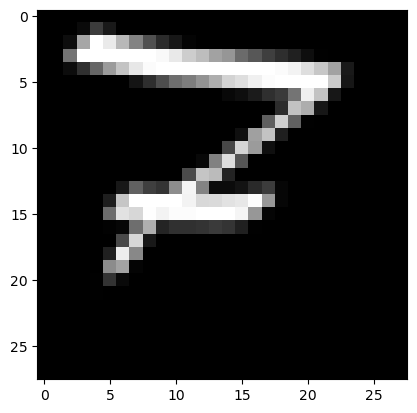

In [76]:
draw_number()
inp = PIL.Image.open('user_input.jpg')
pic_arr =  torch.tensor(np.asarray(inp.resize((28,28)))).type(torch.float)
plt.imshow(pic_arr, cmap = 'gray')
res = model_SF(pic_arr.reshape(-1,28**2))
_, yhat = torch.max(res,1)
print("The softmax model deems the input as the number {}.".format(yhat.numpy()[0]))

The Softmax model has an accuracy of about 92% on the test set, which is already not too bad but judging from the ability of classifying custom input there is still room for improvement.
Let us thus now consider a neural net with one hidden layer as we did in the previous example.

In [77]:
model_NN = Net(28**2,100,10)
criterion_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_NN.parameters(), lr = 0.1)
trainloader = DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = DataLoader(dataset= test_dataset, batch_size=1000)

In [123]:
def train_model_MNIST_NN(epochs,model, use_cuda = False):
    N_test = len(test_dataset)
    LOSS = []
    ACC = []
    if use_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
    for epoch in range(epochs):
        for x,y in trainloader:
            if use_cuda:
                x,y = x.to(device),y.to(device)
            optimizer.zero_grad()
            yhat = model(x.view(-1,28**2))
            loss = criterion_CEL(yhat,y)
            loss.backward()
            optimizer.step()
        correct = 0
        for xt,yt in validation_loader:
            if use_cuda:
                xt,yt = xt.to(device),yt.to(device)
            yt_hat = model(xt.view(-1,28**2))
            _, yt_hat = torch.max(yt_hat.data,1)
            correct += (yt_hat == yt).sum().item()
            acc = correct/N_test
        LOSS.append(loss.data)
        ACC.append(acc)
        if (epoch+1)%5 == 0:
            print("epoch:{}".format(epoch+1))
    return LOSS, ACC


In [79]:
[LOSS_NN, ACC_NN] = train_model_MNIST_NN(20, model_NN)


epoch:5
epoch:10
epoch:15
epoch:20


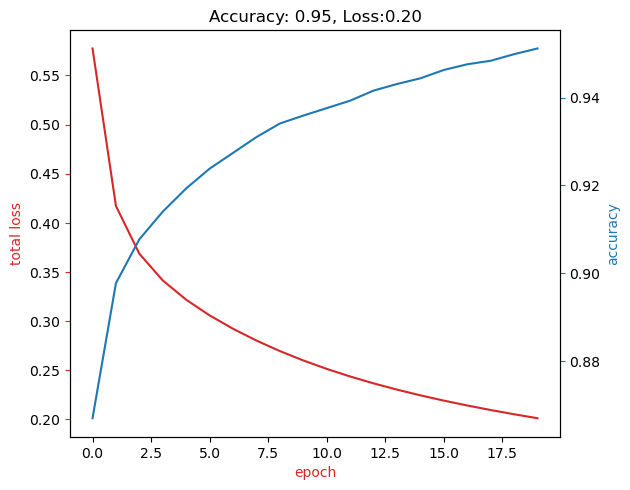

In [80]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS_NN,color=color)
ax1.set_xlabel('epoch',color=color)
ax1.set_ylabel('total loss',color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(ACC_NN, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.title("Accuracy: {0:.2f}, Loss:{1:.2f}".format(ACC_NN[-1],LOSS_NN[-1]));

The softmax model deems the input as the number 2.


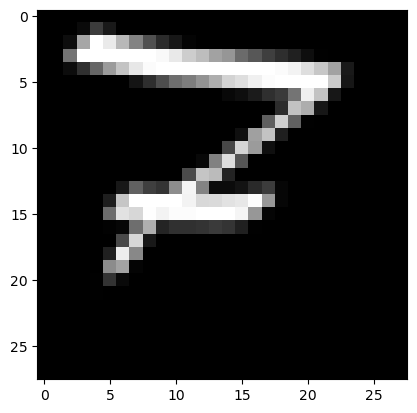

In [81]:
inp = PIL.Image.open('user_input.jpg')
pic_arr =  torch.tensor(np.asarray(inp.resize((28,28)))).type(torch.float)
plt.imshow(pic_arr, cmap = 'gray')
res = model_NN(pic_arr.reshape(-1,28**2))
_, yhat = torch.max(res,1)
print("The softmax model deems the input as the number {}.".format(yhat.numpy()[0]))

In [82]:
print(ACC_NN[-1])

0.9512


In [83]:
model_NN_ReLu = nn.Sequential(nn.Linear(input_dim,100),nn.ReLU(),nn.Linear(100,output_dim))

In [84]:
criterion_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_NN_ReLu.parameters(), lr = 0.1)
trainloader = DataLoader(dataset = train_dataset, batch_size = 100)
validation_loader = DataLoader(dataset= test_dataset, batch_size=1000)
[LOSS_NN_ReLu, ACC_NN_ReLU] = train_model_MNIST_NN(20, model_NN_ReLu)

epoch:5
epoch:10
epoch:15
epoch:20


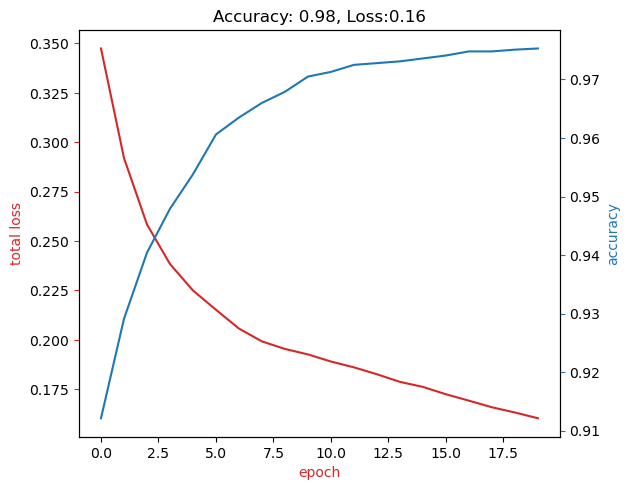

In [85]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS_NN_ReLu, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(ACC_NN_ReLU, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.title("Accuracy: {0:.2f}, Loss:{1:.2f}".format(ACC_NN_ReLU[-1],LOSS_NN_ReLu[-1]));


The softmax model deems the input as the number 9.


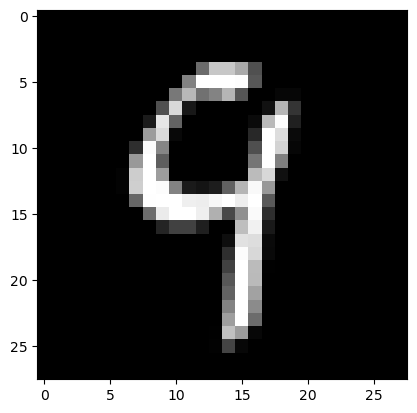

In [86]:
inp = PIL.Image.open('user_input.jpg')
inp = PIL.Image.open('9.jpg')
pic_arr =  torch.tensor(np.asarray(inp.resize((28,28)))).type(torch.float)
plt.imshow(pic_arr, cmap = 'gray')
res = model_NN_ReLu(pic_arr.reshape(-1,28**2))
_, yhat = torch.max(res,1)
print("The softmax model deems the input as the number {}.".format(yhat.numpy()[0]))

In [124]:
layer1_dim = 100
layer2_dim = 100
model_NN_ReLu_deep = nn.Sequential(nn.Linear(input_dim, layer1_dim), nn.ReLU(),
                                   nn.Linear(layer1_dim,layer2_dim), nn.ReLU(),
                                   nn.Linear(layer2_dim, output_dim)
                                   )
criterion_CEL = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_NN_ReLu_deep.parameters(), lr=0.1)
trainloader = DataLoader(dataset=train_dataset, batch_size=100)
validation_loader = DataLoader(dataset=test_dataset, batch_size=1000)


In [125]:
%time [LOSS_NN_ReLu_deep, ACC_NN_ReLU_deep] = train_model_MNIST_NN(20, model_NN_ReLu_deep)

epoch:5
epoch:10
epoch:15
epoch:20
CPU times: total: 20min 36s
Wall time: 2min 35s


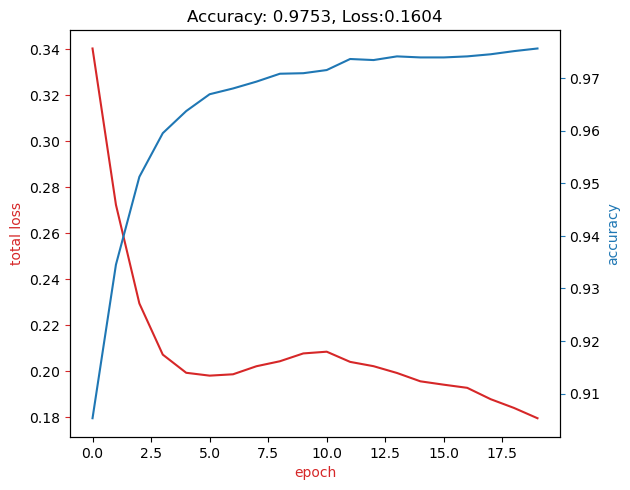

In [126]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS_NN_ReLu_deep, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(ACC_NN_ReLU_deep, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.title("Accuracy: {0:.4f}, Loss:{1:.4f}".format(ACC_NN_ReLU[-1],LOSS_NN_ReLu[-1]));


The softmax model deems the input as the number 9.


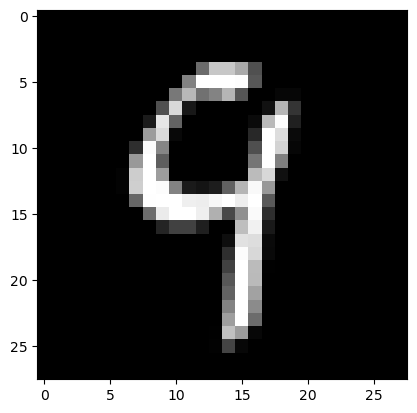

In [127]:
inp = PIL.Image.open('user_input.jpg')
inp = PIL.Image.open('9.jpg')
pic_arr =  torch.tensor(np.asarray(inp.resize((28,28)))).type(torch.float)
plt.imshow(pic_arr, cmap = 'gray')
res = model_NN_ReLu_deep(pic_arr.reshape(-1,28**2))
_, yhat = torch.max(res,1)
print("The softmax model deems the input as the number {}.".format(yhat.numpy()[0]))

In [128]:
%time [LOSS_NN_ReLu_deep, ACC_NN_ReLU_deep] = train_model_MNIST_NN(20, model_NN_ReLu_deep, use_cuda = True )

epoch:5
epoch:10
epoch:15
epoch:20
CPU times: total: 2min 28s
Wall time: 2min 29s


In [131]:
LOSS_NN_ReLu_deep = torch.tensor(LOSS_NN_ReLu_deep, device = 'cpu')
ACC_NN_ReLU_deep = torch.tensor(ACC_NN_ReLU_deep, device = 'cpu')

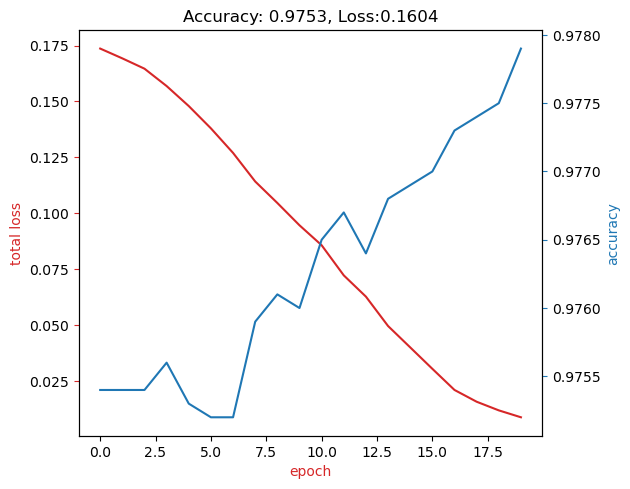

In [132]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(LOSS_NN_ReLu_deep, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('total loss', color=color)
ax1.tick_params(axis='y', color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)
ax2.plot(ACC_NN_ReLU_deep, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.title("Accuracy: {0:.4f}, Loss:{1:.4f}".format(ACC_NN_ReLU[-1],LOSS_NN_ReLu[-1]));


The softmax model deems the input as the number 9.


C:\Users\Rick\AppData\Local\Temp\ipykernel_19748\2092463072.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res = torch.tensor(model_NN_ReLu_deep(pic_arr.reshape(-1,28**2).to(device)),device= 'cpu')


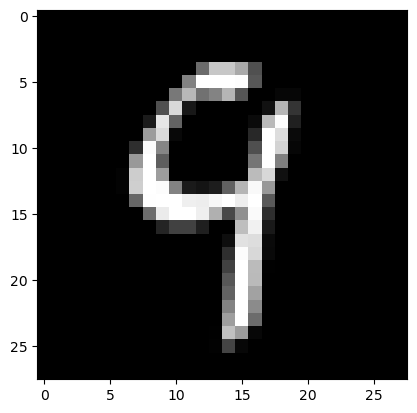

In [145]:
inp = PIL.Image.open('user_input.jpg')
inp = PIL.Image.open('9.jpg')
pic_arr =  torch.tensor(np.asarray(inp.resize((28,28)))).type(torch.float)
plt.imshow(pic_arr, cmap = 'gray')
res = torch.tensor(model_NN_ReLu_deep(pic_arr.reshape(-1,28**2).to(device)),device= 'cpu')
_, yhat = torch.max(res,1)
print("The softmax model deems the input as the number {}.".format(yhat.numpy()[0]))